# Modelo de Rozenberg 5.6i Redes
### Funcion memristor & Funcion PySpice

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import import_ipynb
import networkx as nx
import os

In [2]:
from Memristorfunction import memristor
from PySpicefunction import funcion_pyspice

importing Jupyter notebook from Memristorfunction.ipynb
importing Jupyter notebook from PySpicefunction.ipynb


### Definicion de parametros

In [3]:
################# Configuring electrical signal ################

Vmax = 1500             # Absolute value
pol = 1                 # Polaridad de la corriente --> pol = 1 Primer ciclo positivo / #pol = -1 Primer ciclo negativo
s = 1000                # Cantidad de pasos por ciclo unitario # Absolute value
n_ciclos = 10

In [4]:
################# Configuracion de la red ################

Nc=3    #N° columnas (nodos)
Mf=3    #N° filas (nodos)

N_res=((Nc*(Mf-1))+(Mf*(Nc-1)))  #Numero de resistencias que componen la red
N_res_lista = list(range(0, N_res))

In [5]:
folder = 'V,S,n,NxN_'+str(Vmax)+','+str(s)+','+str(n_ciclos)+','+str(Nc)+'x'+str(Mf)
os.mkdir(f'C:/Users/Jonathan/Jupiter/GITHUB/{folder}')

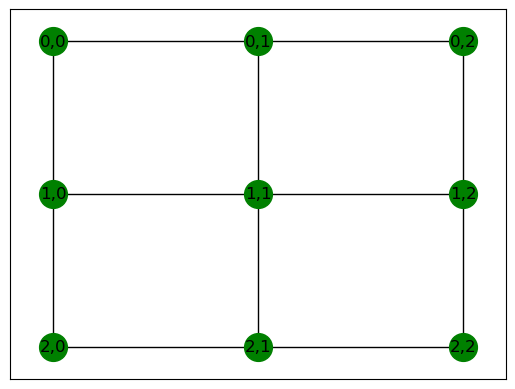

Graph with 9 nodes and 12 edges


In [6]:
#Grafico de los nodos de la red
graph=nx.grid_2d_graph(Mf, Nc)
pos = {(x,y):(y,-x) for x,y in graph.nodes()}
labels = dict(((i, j), f"{i},{j}") for i, j in graph.nodes())
#plt.close()
nx.draw_networkx(graph, pos=pos, labels=labels, node_size=400, node_color="green")
plt.rc('figure', figsize=(6,6))
plt.show()
print(graph)

In [7]:
#Formato para exportar los datos
labels3 = dict(((i, j), f"L{i}{j}") for i, j in graph.edges())
#print(labels3.values()) #keys() or items() 

header = []
header.append(str('time'))
for value in labels3.values():
#list_2=list(labels3.values() for value in d.values())
    header.append(value)
#header.replace(", ", ';')

res = []
for ele in header:  
    # adding each string after replacement using replace()
    res.append(ele.replace(", ", '; '))
    
# print(header)
# print(res)

In [8]:
NL, NR, NB, N = (1, 1, 10, 12)     # Cantidad de bines, Tamaño de la zona de contactos derecha e izquierda
n = list(range(0,N))
AL, AR, AB = (10000, 1000, 1)      # Resistividad en los extremos del dielectrico

#Parametros de distribucion de vacancias inicial
d_inicial=0.0018
fdid=10                     # Factor de densidad inicial de vacancias extremo derecho  ## Ratio
fdii=10                     # Factor de densidad inicial de vacancias extremo izquierdo  ## Ratio

In [9]:
#Densidad de vacancias inicial
Matriz_vac = [[0 for col in range(N)] for row in range(N_res)]

for f in range(0, N_res):
    for i in n:
        if i==0:
            Matriz_vac[f][i]=0
        elif i==1:
            Matriz_vac[f][i]=d_inicial*fdii
        elif i ==len(n)-2:
            Matriz_vac[f][i]=d_inicial*fdid
        elif i ==len(n)-1:
            Matriz_vac[f][i]=0
        else:
            Matriz_vac[f][i]=d_inicial

In [10]:
############# Definicion de la señal electrica ###############

#Ciclo de tension unitario
tau= n_ciclos*s               #Tiempo total del experimento
k = Vmax / (s/4)              #Pendiente de la rampa

t_ciclo_unitario = list(range(0,s))
V_unitario       = list(range(0,s))

for t in range(0,s):
    if (0 <= t <s/4):
        V_unitario[t]= pol*(k*t)
    if (s/4 <= t <=s*3/4):
        V_unitario[t]= pol*(2*Vmax-k*t)
    if (s*3/4 < t <=s):
        V_unitario[t]= pol*(-4*Vmax+k*t)

#Ciclo de tension del experimento
t_ciclo = list(range(0,tau))
V_total = list(range(0,0))

for k in range(0,n_ciclos):
    V_total=V_total+V_unitario

In [11]:
Matriz_rho     = [[0 for col in range(tau)] for row in range(N_res)]
Matriz_voltuni = [[0 for col in range(tau)] for row in range(N_res)]
rho_res        = list(range(0,N_res))
V_res_unitario = list(range(0,N_res))

In [12]:
#Resistividad local especifica
#Pueden introducirse cambios en dispositivos individuales

AJ = [[0 for col in range(3)] for row in range(N_res)]

for i in N_res_lista:
    AJ[i]=(10000,1000,1)

In [13]:
############ DESIGNACIÓN DE LOS ELEMENTOS CON EL ORDEN DE LOS EDGES EN NETWORKX ###########

# Definimos la geometria de la red en una matriz que definira el Netlist y calcular ΔV
# Nc=columnas #N° columnas (nodos)
# Mf=filas #N° filas (nodos)

N_res=((Nc*(Mf-1))+(Mf*(Nc-1)))  #Calculamos el numero de resistencias de la red
Nnodos= Nc*Mf #print('Nres=', Nres)

Matriz1b = [[0 for col in range(4)] for row in range(N_res+2)]

for j in range(0, Mf-1):
    for i in range(0, Nc-1):
        p=2*(i+1)+(Mf+Nc-1)*j
        Matriz1b[p]=(p, (i+1)+(Nc*j), (i+2)+(Nc*j), 0)
        
for i in range(0, Nc-1):
    p=N_res-Nc+i+2
    Matriz1b[p]=(p, Nc*Mf-Nc+1+i, Nc*Mf-Nc+2+i, 0)
            
for j in range(0, Mf-1):
    for i in range(0, Nc):
        q=(Mf+Nc-1)*j+1+2*i
        Matriz1b[q]=(q, (i+1)+(Nc*j), (i+Nc+1)+(Nc*j), 0)

Matriz1b.pop(0)

[0, 0, 0, 0]

In [14]:
# Celda para probar configuraciones con CC en la red
# https://masterplc.com/simulador/
#rho_res2 = list(range(0,N_res))
#for f in range(0, N_res):                                                        
        #rho_res2[f]=1
#V_res_unitario = funcion_pyspice(Matriz1b, 10, rho_res2, Nc, Mf)
#for i in range(0, N_res):
    #print('{} {:6.2}'.format('ΔV Res '+str(i+1), V_res_unitario[i]))

### Loop principal

In [15]:
for t in t_ciclo:
    rho_sum=0
    for f in N_res_lista:                                    #Calculamos la resistencia de cada memristor
        for i in n:
            if i < NL:
                rho_sum=rho_sum+((AJ[f][0])*(Matriz_vac[f][i]))*1
            elif i >=len(n)-NR:
                rho_sum=rho_sum+((AJ[f][1])*(Matriz_vac[f][i]))*1
            else:
                rho_sum=rho_sum+((AJ[f][2])*(Matriz_vac[f][i]))*1
        Matriz_rho[f][t]=rho_sum
        rho_sum=0
    
    for f in N_res_lista:                                                        
        rho_res[f]=Matriz_rho[f][t]                         #Guardamos la resistencia de cada memristor en una matriz
    
    #Aplicamos pyspice para resolver la malla
    V_res_unitario = funcion_pyspice(Matriz1b, V_total[t], rho_res, Nc, Mf)
    
    #Guardamos las caidas de tension unitarias en una matriz
    for f in N_res_lista:
        Matriz_voltuni[f][t]= V_res_unitario[f]
    
    #Aplicamos la funcion memristor para cada elemn
    for f in N_res_lista:
        (Matriz_vac[f])= memristor(V_res_unitario[f], Matriz_vac[f],(AJ[f]))

2023-11-03 11:17:06,083 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Unsupported Ngspice version 38


In [16]:
#Definimos variables auxiliares para graficar
V_normalizada= list(range(0,tau))
t_ciclo2     = list(range(0,tau))    #Para graficar en funcion del N°Ciclo y no de cada step "s"

for t in t_ciclo:
    V_normalizada[t]= V_total[t]/Vmax
    t_ciclo2[t]= t_ciclo[t]/s

In [17]:
#Resistencia total del conjunto
#Calculamos la corriente total que atraviesa la red como la suma de las corrientes que atraviesan R1 y R3.
#R3 queda expresado en funcion de la geometria de la malla
#Rho_total se calcula como V/I en los puntos donde I_total es diference de 0 para evitar indeterminaciones
I_total = list(range(0,tau))
rho_total = list(range(0,tau))

for t in t_ciclo:
    I_total[t] = (Matriz_voltuni[0][t]/Matriz_rho[0][t])+(Matriz_voltuni[(Nc-1)][t]/Matriz_rho[(Nc-1)][t])
    if (I_total[t]==0):
        rho_total[t]=rho_total[t-1]
    else:
        rho_total[t] = V_total[t]/I_total[t]

In [18]:
#Exportar t, V e I a un ascii para analisis posterior

NetColl = []
NetColl.append(t_ciclo)
NetColl.append(V_total)
NetColl.append(I_total)

NetCollt = pd.DataFrame(NetColl).T

NetCollt.to_csv(f'{folder}/tVI.csv',index=False, header=['t','V','I'])#decimal='.', sep= "tab", 

### Análisis y gráficos

In [19]:
#Ciclo a partir del cual comienzo a graficar
cic=0

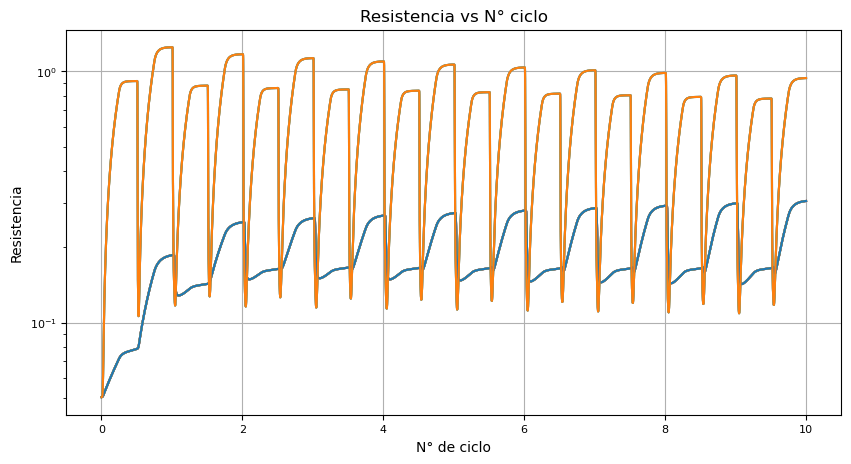

In [20]:
plt.rc('figure', figsize=(10,5))
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)
plt.grid(True)
for f in range(0, N_res):
    plt.semilogy(t_ciclo2[cic*s+1:], Matriz_rho[f][cic*s+1:], label='Rho '+str(f+1))
#plt.legend()
plt.xlabel('N° de ciclo')
plt.ylabel('Resistencia')
plt.title('Resistencia vs N° ciclo', fontsize=12)
plt.savefig(f'{folder}/R_vs_t.png')
plt.show()

In [21]:
#Exportar t y 'Rho '+str(f+1) for f in range(0, N_res)

MemStates = []
MemStates.append(t_ciclo)

for f in range(0, N_res):
    MemStates.append(Matriz_rho[f])
    
MemStatest = pd.DataFrame(MemStates).T

MemStatest.to_csv(f'{folder}/states.csv', header=res , index=False)

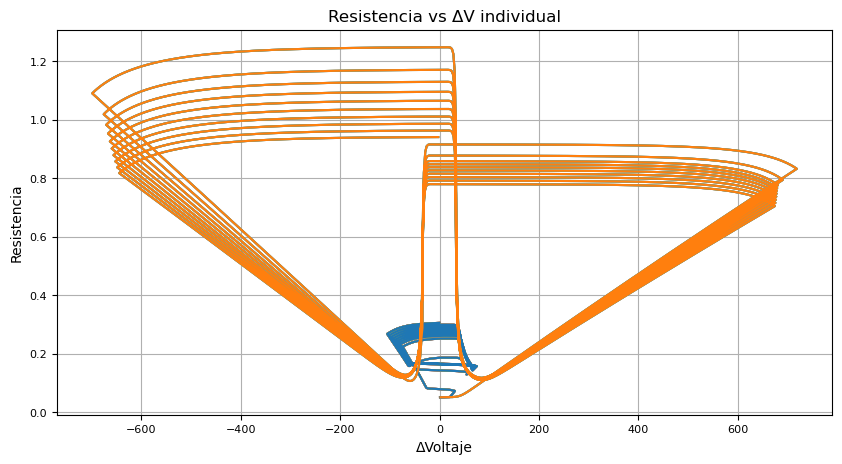

In [22]:
plt.rc('figure', figsize=(10,5))
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)
plt.grid(True)

for f in range(0, N_res):
    plt.plot(Matriz_voltuni[f][cic*s+1:], Matriz_rho[f][cic*s+1:], label='Rho '+str(f+1))
#plt.legend()
plt.xlabel('ΔVoltaje')
plt.ylabel('Resistencia')
plt.title('Resistencia vs ΔV individual', fontsize=12)
plt.savefig(f'{folder}/Ri_vs_V.png')
plt.show()

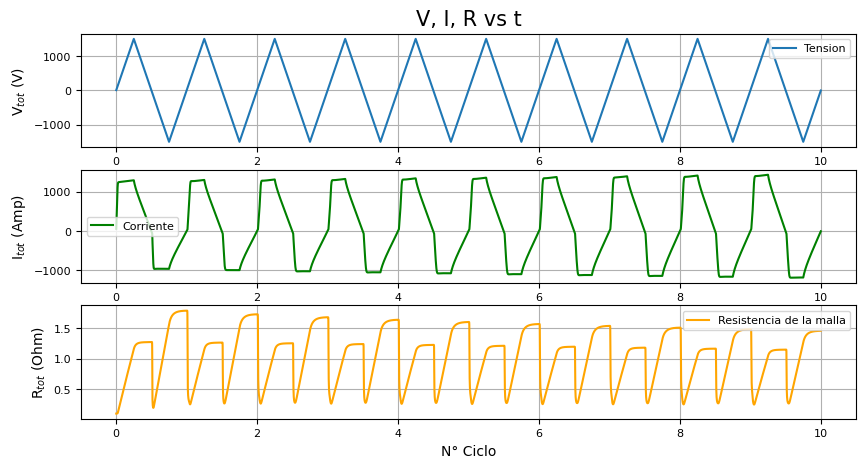

In [23]:
plt.rc('figure', figsize=(10,5))
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)

plt.subplot(3, 1, 1)
plt.grid(True)
plt.title('V, I, R vs t', fontsize=15)
plt.plot(t_ciclo2[cic*s+1:], V_total[cic*s+1:], label='Tension')
plt.legend()
plt.ylabel('V$_{tot}$ (V)')

####
plt.subplot(3, 1, 2)
plt.grid(True)
plt.plot(t_ciclo2[cic*s+1:], I_total[cic*s+1:], label='Corriente', color='green')
plt.legend()
plt.ylabel('I$_{tot}$ (Amp)')

####
plt.subplot(3, 1, 3)
plt.grid(True)
plt.plot(t_ciclo2[cic*s+1:], rho_total[cic*s+1:], label='Resistencia de la malla', color='orange')
plt.legend()
plt.ylabel('R$_{tot}$ (Ohm)')

plt.xlabel('N° Ciclo')
##########
plt.savefig(f'{folder}/T_vs_t.png')
plt.show()

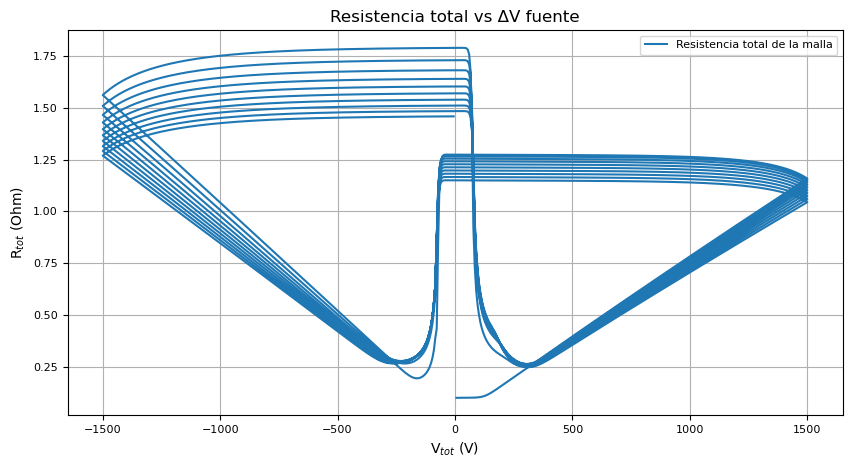

In [24]:
#Graficamos para la red completa:
plt.rc('figure', figsize=(10,5))
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)
plt.grid(True)
plt.plot(V_total[cic*s+1:], rho_total[cic*s+1:], label='Resistencia total de la malla')
plt.legend()
plt.xlabel('V$_{tot}$ (V)')
plt.ylabel('R$_{tot}$ (Ohm)')
plt.title('Resistencia total vs ΔV fuente', fontsize=12)
plt.savefig(f'{folder}/Rtot_vs_V.png')
plt.show()

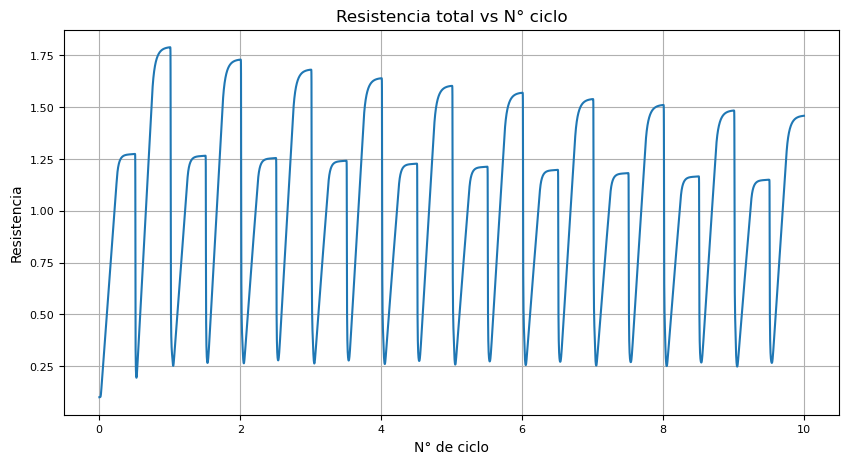

In [25]:
#Resistencia total vs N° ciclo
plt.rc('figure', figsize=(10,5))
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)
plt.grid(True)
plt.plot(t_ciclo2[cic*s+1:], rho_total[cic*s+1:])
#plt.legend()
plt.xlabel('N° de ciclo')
plt.ylabel('Resistencia')
plt.title('Resistencia total vs N° ciclo', fontsize=12)
plt.savefig(f'{folder}/Rtotal_vs_t.png')
plt.show()

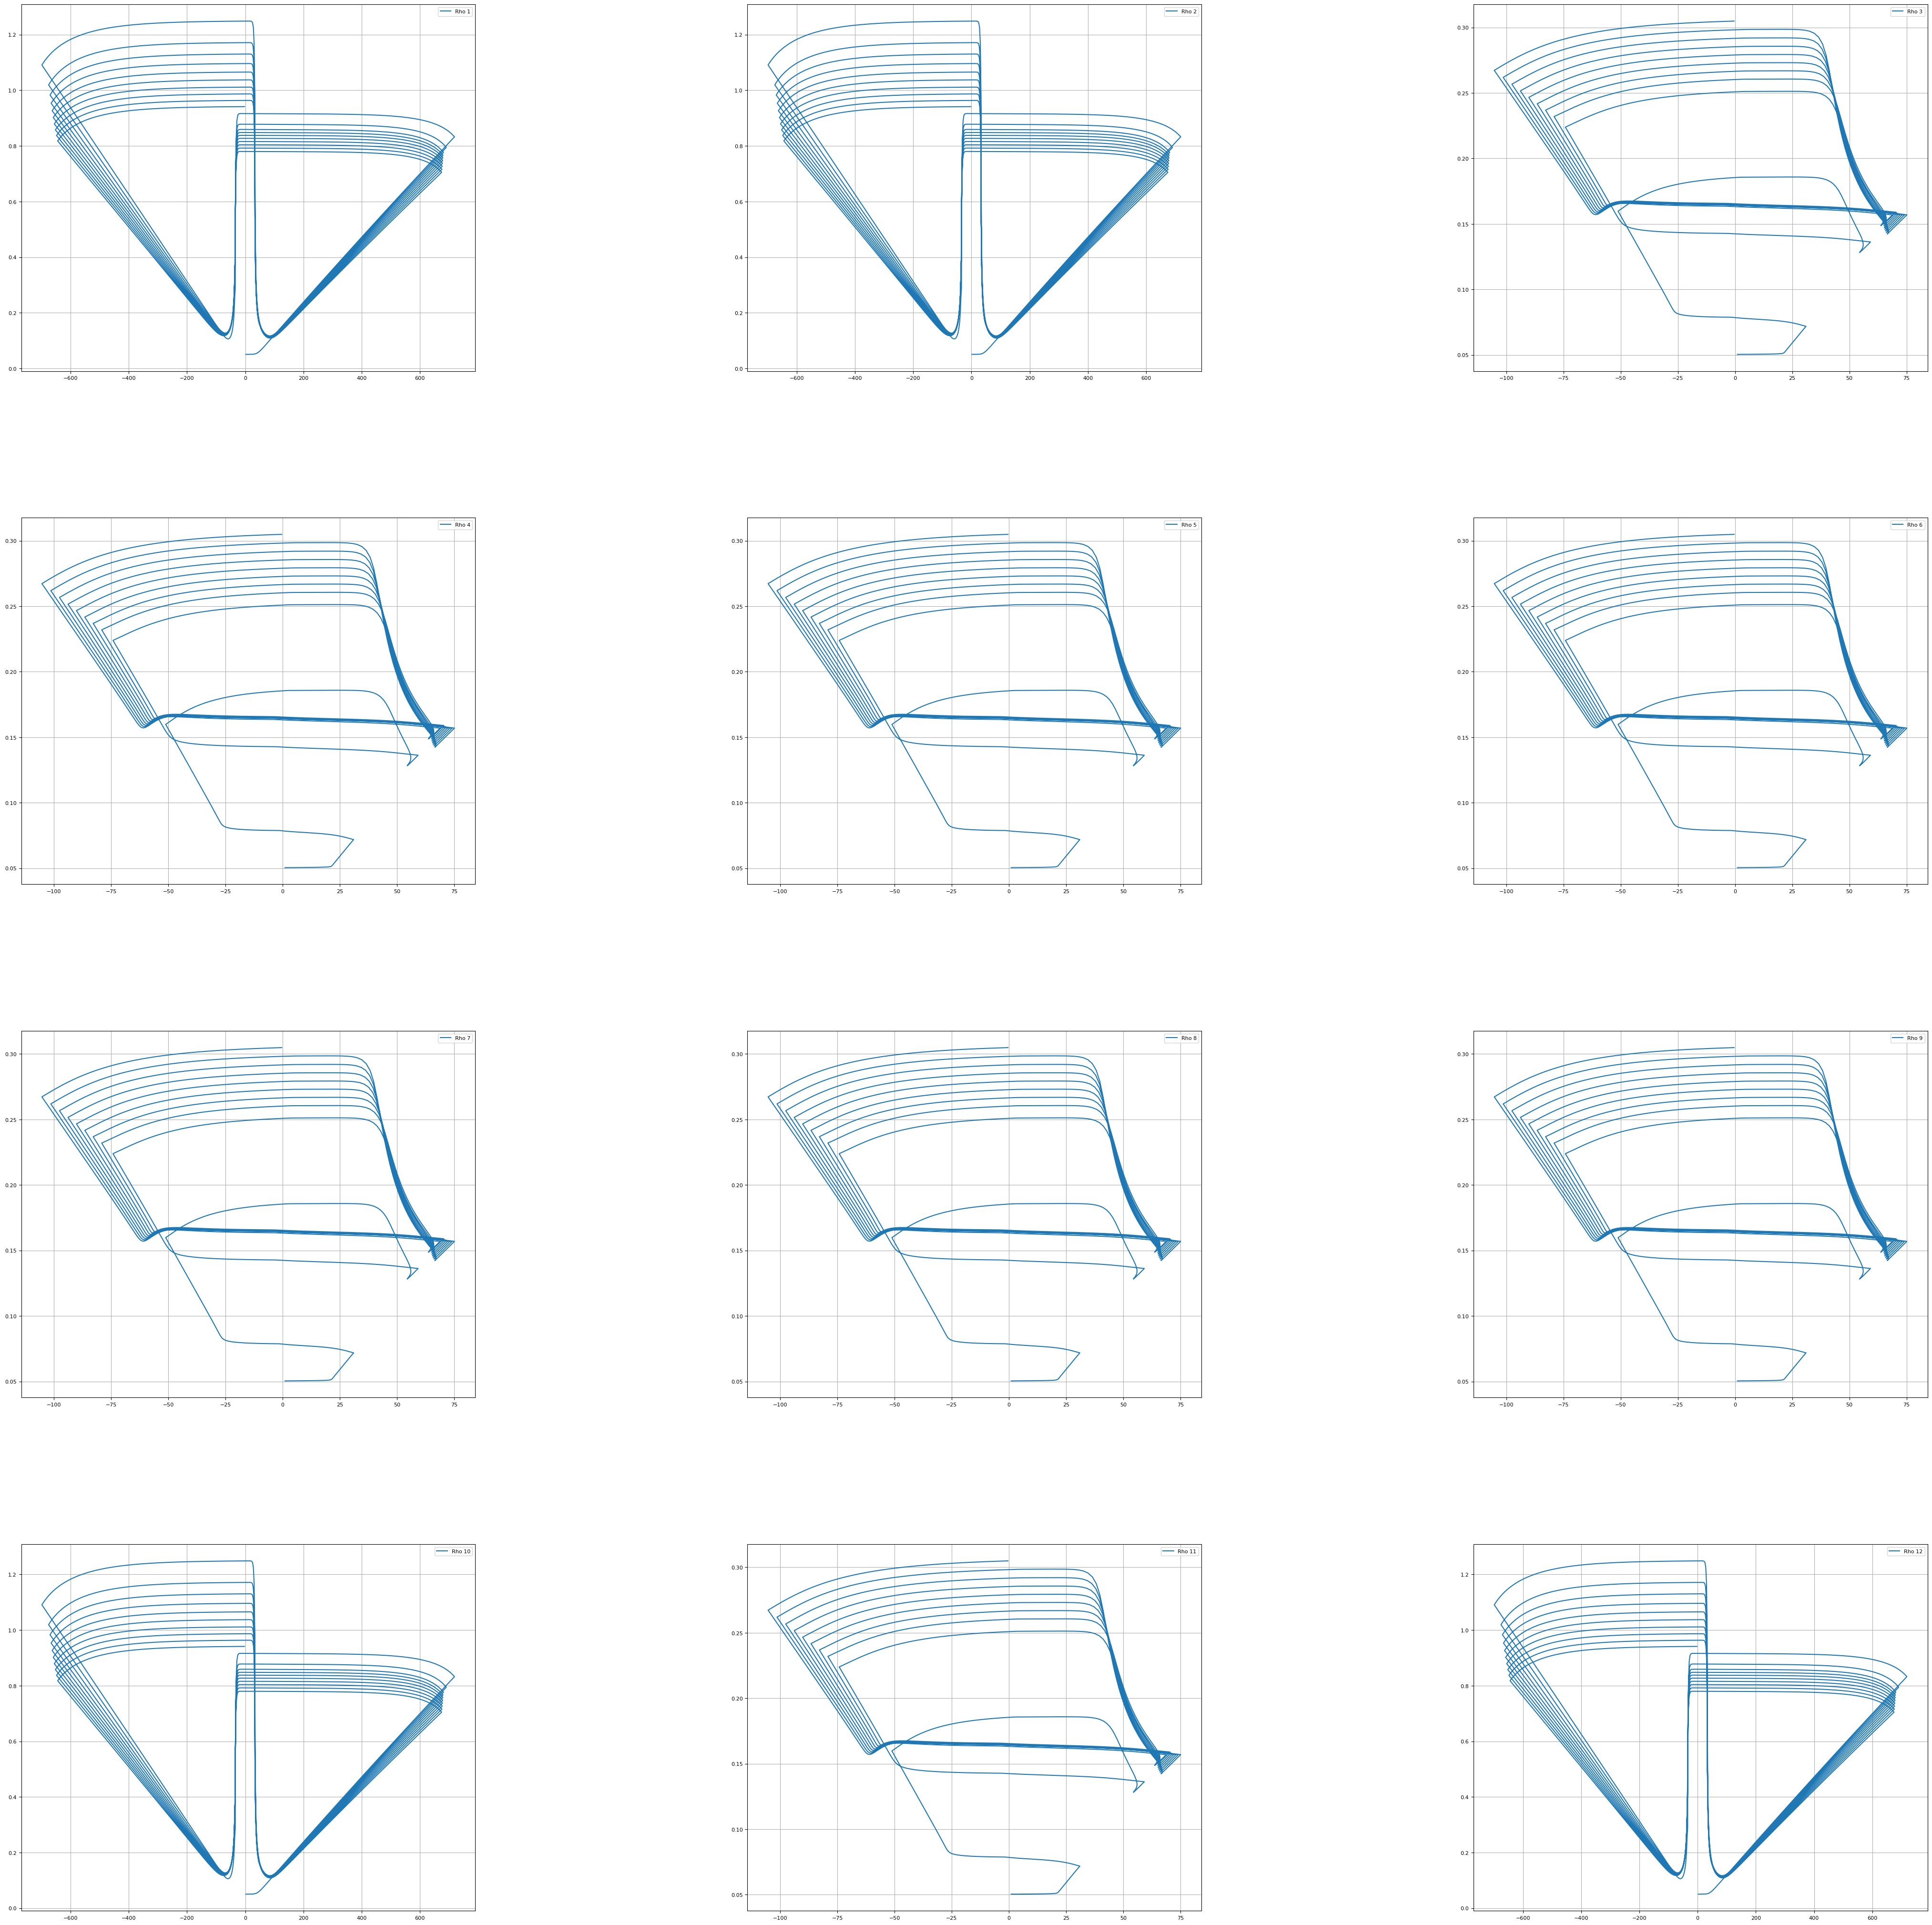

In [26]:
plt.rc('figure', figsize=(50,50))
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)
#plt.title('V, I, R vs t', fontsize=12)

for i in range(0,N_res):
    plt.subplot(((Nc*2)-2), Nc, (i+1))
    plt.grid(True)
    plt.plot(Matriz_voltuni[i][cic*s+1:], Matriz_rho[i][cic*s+1:], label='Rho '+str(i+1))
    plt.legend()
#plt.ylabel('R$_{tot}$ (Ohm)')
#plt.xlabel('V aplicado')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.6,
                    hspace=0.4)
plt.savefig(f'{folder}/HSL.png')
#plt.show()